In computer vision, we normally solve one of the following problems:

* Image Classification is the simplest task, when we need to classify an image into one of many pre-defined categories, for example, distinguish a cat from a dog on a photograph, or recognize a handwritten digit.

* Object Detection is a bit more difficult task, in which we need to find known objects on the picture and localize them, i.e. return the bounding box for each of recognized objects.

* Segmentation is similar to object detection, but instead of giving bounding box we need to return an exact pixel map outlining each of the recognized objects.

![vision.png](Images/vision.png)

## Images as Tensors

Computer Vision works with Images. As you probably know, images consist of pixels, so they can be thought of as a rectangular collection (array) of pixels.

In the first part of this tutorial, we will deal with handwritten digit recognition. We will use the MNIST dataset, which consists of grayscale images of handwritten digits, 28x28 pixels. Each image can be represented as 28x28 array, and elements of this array would denote intensity of corresponding pixel - either in the scale of range 0 to 1 (in which case floating point numbers are used), or 0 to 255 (integers). A popular python library called numpy is often used with computer vision tasks, because it allows to operate with multidimensional arrays effectively.

To deal with color images, we need some way to represent colors. In most cases, we represent each pixel by 3 intensity values, corresponding to Red (R), Green (G) and Blue (B) components. This color encoding is called RGB, and thus color image of size W×H will be represented as an array of size H×W×3 (sometimes the order of components might be different, but the idea is the same).

Multi-dimensional arrays are also called tensors. Using tensors to represent images also has an advantage, because we can use an extra dimension to store a sequence of images. For example, to represent a video fragment consisting of 200 frames with 800x600 dimension, we may use the tensor of size 200x600x800x3.
## TensorFlow and Keras versions


In [1]:
#Import the packages needed.
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os

# In this tutorial, we will be training a lot of models. In order to use GPU memory cautiously,
# we will set tensorflow option to grow GPU memory allocation when required.
physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices)>0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

print(tf.__version__)

2023-12-30 10:02:47.428196: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-30 10:02:49.789558: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-30 10:02:49.789658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-30 10:02:50.184872: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-30 10:02:50.944190: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-30 10:02:50.945074: I tensorflow/core/platform/cpu_feature_guard.cc:1

2.15.0


TensorFlow is now at version 2, and it differs significantly between versions 1 and 2. Thus it is important to check that we have correct version, otherwise the code is likely not to work.

In version 2 TensorFlow added a higher-level neural network construction API called Keras. With Keras, most model building steps can be done in a much simpler way. This has made Keras a preferred way to start training deep learning networks. Only switching to pure TensorFlow when you need to develop some custom architectures for research or more complex scenarios. Since Keras is part of TensorFlow, the terms are used interchangeably and many times when someone says TensorFlow they are actually talking about the Keras.

In this tutorial, we will focused on developing neural networks using Keras in TensorFlow 2.

## Loading the MNIST Dataset

Keras has a [number of datasets](https://www.TensorFlow.org/api_docs/python/tf/keras/datasets) available right from the library. Here we are using the well-known [MNIST](http://yann.lecun.com/exdb/mnist/) dataset of handwritten digits, available through `tf.keras.datasets.mnist`. It has a function `load_data()` that returns train and test MNIST datasets.

When using your own notebooks, you can experiment with the other built in datasets, in particular [FashionMNIST](https://www.TensorFlow.org/api_docs/python/tf/keras/datasets/fashion_mnist). It has exactly the same shape as MNIST, but contains outlines of different clothing types. You should be able to experiment with FashionMNIST by simply replacing the dataset name below.


In [2]:
(x_train,y_train),(x_test,y_test) = keras.datasets.mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_test.shape,y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


## Visualize the digits dataset
Now that we have downloaded the dataset we can visualize some of the digits

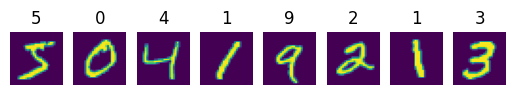

In [3]:
fig, ax = plt.subplots(1, 8)
for i in range(8):
    ax[i].imshow(x_train[i])
    ax[i].set_title(y_train[i])
    ax[i].axis('off')

## Dataset structure

We have a total of 60000 training images (stored in `x_train`) and 10000 testing images (in `x_test`). Labels corresponding to those images are contained in `y_train` and `y_test` accordingly.

In [4]:
print('Training samples:',len(x_train))
print('Test samples:',len(x_test))

print('Tensor size:',x_train[0].shape)
print('First 10 digits are:', y_train[:10])
print('Type of data is ',type(x_train))

Training samples: 60000
Test samples: 10000
Tensor size: (28, 28)
First 10 digits are: [5 0 4 1 9 2 1 3 1 4]
Type of data is  <class 'numpy.ndarray'>


As you can see, the type of data is numpy array, which allows us to manipulate it using any numpy operations. All pixels of the images are represented by integer numbers from 0 to 255:

In [5]:
print('Min intensity value: ',x_train.min())
print('Max intensity value: ',x_train.max())

Min intensity value:  0
Max intensity value:  255


The reason it is between 0 and 255 is because of how color is represented in a binary format. RGB (red, green, blue) are each represented as a 0-255 value to create digital colors.  If we load any image from file using [OpenCV](https://opencv.org/) or [PIL](https://pillow.readthedocs.io/en/stable/) you will end up having numpy array with pixel intensities in the same range [0..255].

> Note: If you are loading color image, the shape of the array would be slightly different, each pixel contains 3 color values (R,G and B). Thus the image 300x300 pixels will be represented by 300x300x3 numpy array.

If we want to feed our images to the neural network, it is important to make sure that all values are scaled to the range [**0 - 1**] before we start training. So, we will rescale the dataset in order to have all values in the required normalized range:

In [6]:
x_train = x_train.astype(np.float32)/255.0
x_test = x_test.astype(np.float32)/255.0

Now we have the data, and we are ready to start training our first neural network!
# Training a dense neural network

The handwritten digit recognition is a classification problem. We will start with the simplest possible approach for image classification - a fully-connected neural network (which is also called a *perceptron*). 

A basic **neural network** consists of a number of **layers**. The simplest network would include just one fully-connected layer, which is called **Dense** layer, with 784 inputs (one input for each pixel of the input image) and 10 outputs (one output for each class). It is called dense because it contains all possible connections between 784 inputs and 10 outputs, 7840 total connections.

As we discussed above, the dimension of our digit images is $28\times28$. Because the input dimension of a fully-connected layer is 784, we need to insert another layer into the network, called **Flatten**, to change tensor shape from $28\times28$ to $784$.

We want $n$-th output of the network to return the probability of the input digit being equal to $n$. Because the output of a fully-connected layer is not normalized to be between 0 and 1, it cannot be thought of as probability. To turn it into a probability we need to apply another layer called **Softmax**.


It can be defined in Keras in the following way, using `Sequential` syntax:

In [7]:
model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(28,28)), 
        keras.layers.Dense(10,activation='softmax')])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Once you have defined a network, you can call the `summary` method to display its architecture and other useful information, such as number of parameters in each layer.

When defining a network, it is important to remember to specify the dimension of the input tensor with the `input_shape` parameter. If you do not do that, Keras is unable to understand how many neurons are required to construct each layer. If `input_shape` is not provided you can still train the network but the summary will be incomplete.

## Anatomy of a Dense Layer

I have mentioned above that a dense layer contains 7840 weighted connections, however, in the `summary` above we see that our dense layer has 7850 parameters. Let's take some time to understand why.

The network input contains 784 pixels, which can be represented by a vector $x$ with 784 numbers. To get an output $z$ of dimension 10 we can multiply it by a matrix $W$ with dimensions $10\times784$: $z=W\times x$.

However, such multiplication defines a linear transformation without shift. Imagine we had only one input value, then the matrix would have just one weight, and the equation $W\times x$ would represent a straight line which goes through the point $(0,0)$. This would not be able to perform arbitrary classifications, because in some cases we also want some **shift** to happen. That means that we need a full equation for a straight line: $z=W\times x + b$, where $b$ is the **bias**.

Similarly, in a dense layer with 784 inputs and 10 outputs, the output would be calculated as $W\times x + b$, where the dimension of **weight** matrix $W$ is $784\times 10$, and the dimension of a **bias** vector $b$ is 10. This gives us $784\times 10 + 10 = 7850$ parameters. 

In Keras, we can get the weight matrix and bias from the `layers` property. Our dense layer is a second layer from the top, thus it can be access using `model.layers[1]`.

In [8]:
model.layers[1].weights

[<tf.Variable 'dense/kernel:0' shape=(784, 10) dtype=float32, numpy=
 array([[-0.08080412, -0.02272029, -0.01838586, ...,  0.07366038,
         -0.02508128, -0.06320372],
        [ 0.04084525, -0.01747786,  0.03560771, ...,  0.01117477,
         -0.07073477,  0.08422927],
        [ 0.06526191,  0.04429884, -0.052553  , ...,  0.0562323 ,
         -0.05372192,  0.04513197],
        ...,
        [-0.06796522, -0.07442064,  0.03435763, ...,  0.02610083,
         -0.01143245, -0.02267279],
        [-0.03626993, -0.06260221, -0.01883871, ...,  0.01342981,
          0.01092486, -0.08460618],
        [-0.06695927, -0.06150006,  0.03580089, ...,  0.01694144,
         -0.03407582, -0.06011839]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>]

As you can see, `weights` property of a layer returns a list of all weights, in our case it is the actual weight matrix called **kernel**, and a **bias**.

## Training the network

A network defined this way can take any digit as input and produce a vector of probabilities as an output. Let's see how this network performs by giving it a digit from our dataset:

In [9]:
print('Digit to be predicted: ',y_train[0])
model(np.expand_dims(x_train[0],0))

Digit to be predicted:  5


<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.06138737, 0.05559804, 0.09516725, 0.08099446, 0.15461296,
        0.15652978, 0.0796834 , 0.12736563, 0.05891674, 0.12974437]],
      dtype=float32)>

The output of the network is the **tensor**, represented by the `ft.Tensor` object. The tensor type is very similar to a numpy array, however TensorFlow can operate on tensors very efficiently, shifting computations to GPU for better performance.

> **Note**: In fact, low-level TensorFlow API contains all basic tensor operations, similar to corresponding numpy operations on arrays. For example, you can use `tf.exp` on tensors, and it would be equivalent to calling `np.exp` on numpy arrays.

As you can see the network predicts similar probabilities for each digit. This is because it has not been trained on how to recognize the digits yet. We need to give it our training data to train it on our dataset.

To train the model we first need to **compile** it:

In [10]:
model.compile(optimizer='sgd',loss='categorical_crossentropy')

When building a model, we specify two important things:
* An **optimizer** that will be used to minimize the error. The simplest optimizer is **stochastic gradient descent**, or SGD; but with more complex networks other optimizers are often used, such as **Adam**
* A **loss function** will be used on the output of the network to obtain the error, which we will then minimize. For this model we will use **categorical cross-entropy** as the loss function.

To train the network, we need to provide an output for each training sample. We have **multi-class classification** problem since the network outputs probabilities for each digit from 0 to 9 (digits). 

We need the expected outputs to have the same layout, i.e. be a 10-number vector that contains 1 in only one position. This is called **one-hot encoding**. For example, digit 5 will be one-hot-encoded by a vector (0 0 0 0 0 1 0 0 0 0).

We can easily one-hot-encode training labels using Keras API:

In [11]:
y_train_onehot = keras.utils.to_categorical(y_train)
y_test_onehot = keras.utils.to_categorical(y_test)
print("First 3 training labels:",y_train[:3])
print("One-hot-encoded version:\n",y_train_onehot[:3])

First 3 training labels: [5 0 4]
One-hot-encoded version:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


Now, to do the actual training, we call the `fit` function:

In [12]:
model.fit(x_train,y_train_onehot)

1875/1875 [==============================] - 2s 852us/step - loss: 0.7800


## Monitoring training

This training only loops through the dataset once, which is called one **epoch**. Normally we want training to go on for several epochs, and we can specify the number of epochs we want using a parameter.

Also, it is useful to evaluate the quality of the model on test and/or a validation datasets. It's important to test the model with unseen data because this will help indicate how well the model **generalizes** to other data beyond our dataset. To evaluate the error in between epochs, we can pass in validation data:

In [13]:
hist = model.fit(x_train,y_train_onehot,validation_data=(x_test,y_test_onehot), epochs=50)

Epoch 1/50
 123/1875 [>.............................] - ETA: 1s - loss: 0.5030

1875/1875 [==============================] - 2s 1ms/step - loss: 0.4566 - val_loss: 0.4010
Epoch 2/50
1875/1875 [==============================] - 2s 959us/step - loss: 0.4038 - val_loss: 0.3686
Epoch 3/50
1875/1875 [==============================] - 2s 995us/step - loss: 0.3774 - val_loss: 0.3493
Epoch 4/50
1875/1875 [==============================] - 2s 948us/step - loss: 0.3606 - val_loss: 0.3373
Epoch 5/50
1875/1875 [==============================] - 2s 956us/step - loss: 0.3487 - val_loss: 0.3275
Epoch 6/50
1875/1875 [==============================] - 2s 986us/step - loss: 0.3397 - val_loss: 0.3207
Epoch 7/50
1875/1875 [==============================] - 2s 962us/step - loss: 0.3325 - val_loss: 0.3156
Epoch 8/50
1875/1875 [==============================] - 2s 959us/step - loss: 0.3266 - val_loss: 0.3103
Epoch 9/50
1875/1875 [==============================] - 2s 971us/step - loss: 0.3218 - val_loss: 0.3074
Epoch 10/50
1875/1875 [==============================] - 2s 984us/step - loss

The `fit` function returns the **history** object that contains the loss data for each training epoch. It can be used to visualize the loss on the graph:

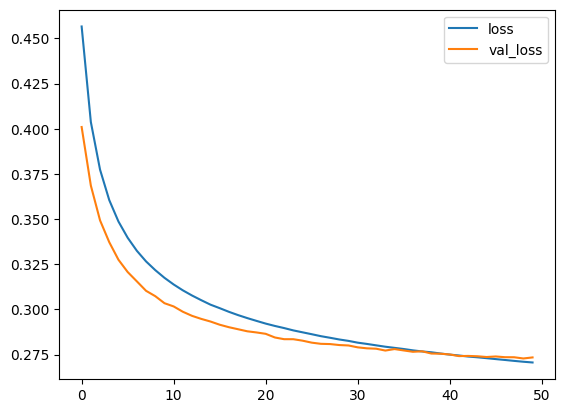

In [14]:
for x in ['loss','val_loss']:
    plt.plot(hist.history[x], label=x)
plt.legend()

## Metrics and Minibatches

The value of the loss function does not tell us a lot about the accuracy of the model. To measure accuracy, we would want to see the percentage of correctly classified digits from the test dataset. In fact, we can add accuracy as a **metric** during dataset compilation, and it would be displayed and reported all the way through the training:

In [15]:
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['acc'])
hist = model.fit(x_train,y_train_onehot,validation_data=(x_test,y_test_onehot), epochs=50,batch_size=128)

Epoch 1/50
469/469 [==============================] - 1s 1ms/step - loss: 0.2696 - acc: 0.9253 - val_loss: 0.2725 - val_acc: 0.9230
Epoch 2/50
469/469 [==============================] - 1s 1ms/step - loss: 0.2695 - acc: 0.9255 - val_loss: 0.2726 - val_acc: 0.9227
Epoch 3/50
431/469 [==========================>...] - ETA: 0s - loss: 0.2695 - acc: 0.9257

469/469 [==============================] - 1s 1ms/step - loss: 0.2694 - acc: 0.9256 - val_loss: 0.2726 - val_acc: 0.9235
Epoch 4/50
469/469 [==============================] - 1s 1ms/step - loss: 0.2693 - acc: 0.9258 - val_loss: 0.2726 - val_acc: 0.9236
Epoch 5/50
469/469 [==============================] - 1s 1ms/step - loss: 0.2692 - acc: 0.9257 - val_loss: 0.2725 - val_acc: 0.9228
Epoch 6/50
469/469 [==============================] - 1s 1ms/step - loss: 0.2691 - acc: 0.9259 - val_loss: 0.2727 - val_acc: 0.9234
Epoch 7/50
469/469 [==============================] - 1s 1ms/step - loss: 0.2690 - acc: 0.9258 - val_loss: 0.2723 - val_acc: 0.9226
Epoch 8/50
469/469 [==============================] - 1s 1ms/step - loss: 0.2689 - acc: 0.9258 - val_loss: 0.2723 - val_acc: 0.9229
Epoch 9/50
469/469 [==============================] - 1s 1ms/step - loss: 0.2688 - acc: 0.9256 - val_loss: 0.2723 - val_acc: 0.9230
Epoch 10/50
469/469 [==============================] - 1s 1ms/step - loss: 0.2687 - acc

In addition to using new accuracy metrics, we have specified `batch_size` parameter to define the number of samples that are being processed by the neural network at once. Since GPU computations are easily parallelizable, it is much more efficient to process several samples in one go. Larger minibatch size significantly speeds up learning process, but also makes it a little bit less precise. This is due to the fact that the direction of optimization is selected for the whole minibatch, and not for each individual sample. Thus, choosing minibatch size is quite tricky, and it remains one of the hyperparameters that can be further optimized to achieve better performance. 

## Specifying Optimizer Parameters

In the previous call to `compile`, we have been specifying optimizer, loss and metrics using keyword abbreviations, such as `sgd`. However, sometimes we might want to do some fine-tuning to optimizer parameters, or use custom loss function. In such cases, it is possible to pass objects instead of string abbreviations.

Let's use a variation of stochastic gradient descent, which is called **momentum SGD**. The idea is that the gradients of loss function will be averaged over the last few steps in order to keep the momentum, and make optimization more smooth. To turn our gradient descent into momentum SGD, we need to create `SDG` optimizer object explicitly, provide `momentum` parameter, and pass this object to `compile` method.

In [16]:
model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(28,28)), 
        keras.layers.Dense(10,activation='softmax')])
model.compile(optimizer=keras.optimizers.SGD(momentum=0.5),loss='categorical_crossentropy',metrics=['acc'])
hist = model.fit(x_train,y_train_onehot,validation_data=(x_test,y_test_onehot), epochs=50, batch_size=64)  

Epoch 1/50
938/938 [==============================] - 1s 1ms/step - loss: 0.7737 - acc: 0.8169 - val_loss: 0.4797 - val_acc: 0.8827
Epoch 2/50
938/938 [==============================] - 1s 1ms/step - loss: 0.4561 - acc: 0.8813 - val_loss: 0.4004 - val_acc: 0.8942
Epoch 3/50
938/938 [==============================] - 1s 1ms/step - loss: 0.4031 - acc: 0.8913 - val_loss: 0.3665 - val_acc: 0.9016
Epoch 4/50
938/938 [==============================] - 1s 1ms/step - loss: 0.3764 - acc: 0.8977 - val_loss: 0.3481 - val_acc: 0.9064
Epoch 5/50
938/938 [==============================] - 1s 1ms/step - loss: 0.3597 - acc: 0.9012 - val_loss: 0.3353 - val_acc: 0.9093
Epoch 6/50
938/938 [==============================] - 1s 1ms/step - loss: 0.3480 - acc: 0.9042 - val_loss: 0.3261 - val_acc: 0.9118
Epoch 7/50
938/938 [==============================] - 1s 1ms/step - loss: 0.3389 - acc: 0.9062 - val_loss: 0.3194 - val_acc: 0.9142
Epoch 8/50
938/938 [==============================] - 1s 1ms/step - loss: 0.

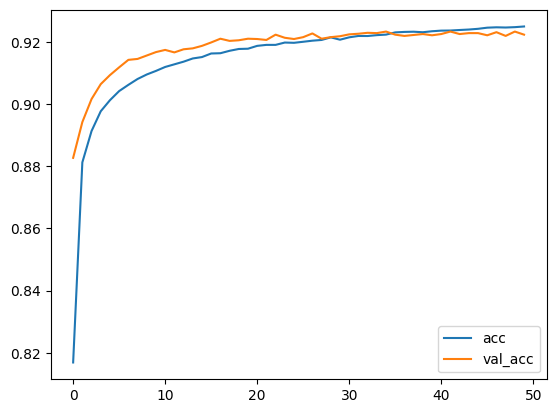

In [17]:
for x in ['acc','val_acc']:
    plt.plot(hist.history[x], label=x)
plt.legend()

## Visualizing network weights

Now let's visualize the weights of our neural network and see what they look like. When the network is more complex than just one layer, making sense of the weight data is more difficult. However, in this example of classifying a digit in a one-layered perceptron happens by multiplying the initial image by a weight matrix, which allows us to visualize the network weights and see if they make any sense.

Let's create a `weight_tensor` which will have a dimension of 784x10. This tensor can be obtained by calling the `net.parameters()` method. In this example, if we want to see if our number is 0 or not, we will multiply input digit by `weight_tensor[0]` and pass the result through a softmax normalization to get the answer. This results in the weight tensor elements somewhat resembling the average shape of the digit it classifies:

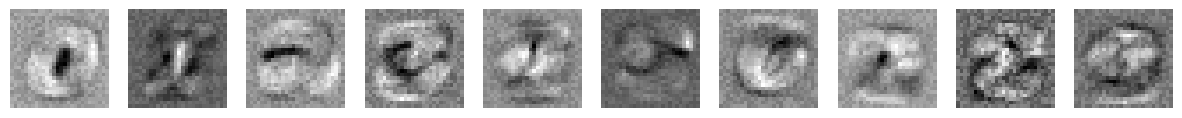

In [18]:
weight_tensor = model.layers[1].weights[0].numpy().reshape(28,28,10)
fig,ax = plt.subplots(1,10,figsize=(15,4))
for i in range(10):
    ax[i].imshow(weight_tensor[:,:,i], cmap='gray')
    ax[i].axis('off')

Bora testar numa image só de zoas aqui, ver se funciona mesmo

(10000, 28, 28)
1/1 [==============================] - 0s 56ms/step
The predicted class is: 7
Actually, it is a: 7


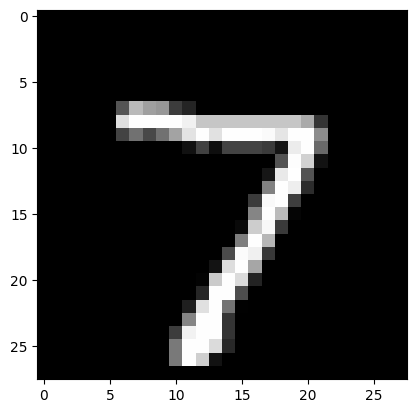

In [19]:
# Let's assume `single_image` is your test image and it's a numpy array with shape (28, 28)
single_image = x_test[0]
print(x_test.shape)
single_image = single_image.reshape(1, 28, 28)

# Now, you can use the model to predict the class of the single image
predictions = model.predict(single_image)

# The output `predictions` is a 2D array with shape (1, 10), where 10 is the number of classes.
# Each value in `predictions[0]` is the model's confidence that the image belongs to that class.
# You can get the predicted class by finding the index of the maximum value.
predicted_class = np.argmax(predictions[0])

print("The predicted class is:", predicted_class)
print("Actually, it is a:", y_test[0])
fig,ax = plt.subplots(1,1)
ax.imshow(x_test[0], cmap='gray')

(28, 28)
1/1 [==============================] - 0s 13ms/step
The predicted class is: 8


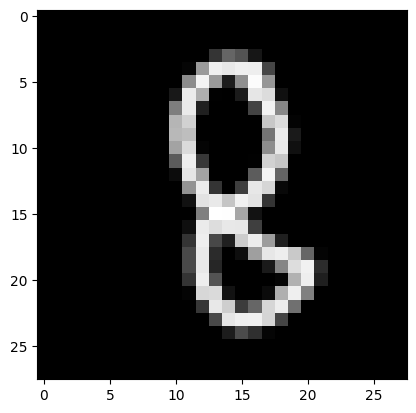

In [28]:
from PIL import Image
import numpy as np
from PIL import ImageOps

# Load the image
img = Image.open('Images/oito.png')


img = img.convert('L')
img = ImageOps.invert(img)

# Convert the image data to a numpy array and normalize pixel values to be between 0 and 1
img_array = np.array(img) / 255.0
np.savetxt('output.txt', img_array, fmt='%f')
print(img_array.shape)
fig,ax = plt.subplots(1,1)
ax.imshow(img_array, cmap='gray')

# Now, you can use the model to predict the class of the image
predictions = model.predict(img_array.reshape(1, 28, 28))

# The output `predictions` is a 2D array with shape (1, 10), where 10 is the number of classes.
# Each value in `predictions[0]` is the model's confidence that the image belongs to that class.
# You can get the predicted class by finding the index of the maximum value.
predicted_class = np.argmax(predictions[0])

print("The predicted class is:", predicted_class)

## Takeaway 

Training a neural network in Keras requires just one line of code and tweaking a few parameters. We can see that a single-layer dense neural network shows relatively good performance, but we definitely want to get higher than 91% on accuracy! In the next unit, we will try to use multi-level perceptrons.